# 1. Setup

In [1]:
import contextily as ctx
import urllib.request
import yaml

from utils import *

# 2. Prepare zones

## 2.1. For the US

### 2.1.1. Download boundaries
Download the zone boundary shapefiles for the entire U.S. for the relevant spatial scales for **2010** and **2020**. However, due to how the TIGER database handles stuff before 2010, the 2011 data is used instead of 2010.

In [2]:
state_codes = pd.read_csv('../data/zones/state_codes.csv').disp()

49 rows x 3 cols; Memory: 0.0 MiB


,name,code,fips
,<object>,<object>,<int64>
0,Alabama,AL,1


In [3]:
def get_us_shp(scale, year, state_codes=state_codes, overwrite=False):
    """Download or load the boundary shapefile of all the US 
    Census regions at the given scale and the given year.
    """
    assert scale in ['bg', 'cbsa', 'county', 'state', 'tract'], scale
    outpath = Path(f'../data/zones/us/{scale}_{year}.parquet')
    if outpath.exists() and not overwrite:
        return gpd.read_parquet(outpath).set_crs(CRS_DEG)
    year_ = max(year, 2011) # to fix the 2010 vs 2011 issue
    base_url = ('https://www2.census.gov/geo/tiger/TIGER{}/{}'
                .format(year_, scale.upper()))
    # for scales available only for the entire US
    if scale in ['cbsa', 'county', 'state']:
        files = [f'tl_{year_}_us_{scale}.zip']
    else: # for scales available only at the state level
        files = [f'tl_{year_}_{fips:02}_{scale}.zip'
                 for fips in state_codes['fips']]
    df = pd.concat([gpd.read_file(f'{base_url}/{f}') for f in files])
    df = df.to_crs(CRS_DEG).rename(columns=str.lower)
    if 'name' not in df.columns:
        df['name'] = ''
    df = df[['geoid', 'name', 'aland', 'awater', 'geometry']]
    df = df.sort_values('geoid').reset_index(drop=True)
    df.to_parquet(mkfile(outpath), compression='gzip')
    return df

# get_us_shp('state', 2010, overwrite=1) # t=0:02
# get_us_shp('state', 2020, overwrite=1) # t=0:02
# get_us_shp('cbsa', 2010, overwrite=1) # t=0:05
# get_us_shp('cbsa', 2020, overwrite=1) # t=0:05
# get_us_shp('county', 2010, overwrite=1) # t=0:11
cnty20 = get_us_shp('county', 2020, overwrite=0).disp() # t=0:12
# get_us_shp('tract', 2010, overwrite=1) # t=0:58
# get_us_shp('tract', 2020, overwrite=1) # t=1:04
# get_us_shp('bg', 2010, overwrite=1) # t=1:37
# get_us_shp('bg', 2020, overwrite=1) # t=1:45

3,234 rows x 5 cols; Memory: 0.5 MiB; CRS: EPSG:4326


,geoid,name,aland,awater,geometry
,<object>,<object>,<int64>,<int64>,<geometry>
0,01001,Autauga,1539634184,25674812,"POLYGON ((-86.903096 32.540626, -86.903115 32...."


### 2.1.2. Lower 48
The original US counties shapefile includes water areas that don't look good. So instead combine tracts (which don't include waters) to counties for the contiguous US.

In [1]:
# # t=1:27
# df = gpd.read_parquet('../data/zones/state_2020.parquet', filters=[
#         ('scale', '==', 'tract')], columns=['geoid', 'aland', 'geometry'])
# df = df.assign(geoid=df.geoid.str[:5]).dissolve('geoid', sum).reset_index()
# df = df.merge(pd.read_parquet('../data/zones/us/county_2020.parquet', 
#                               columns=['geoid', 'name']), on='geoid')
# df = Gdf(df, crs=CRS_DEG).to_crs(CRS_M)['geoid name aland geometry'.split()]
# df.to_parquet('../data/zones/us/county_trim.parquet')

In [ ]:
# # t=0:19
# us_states = (us_counties.assign(geoid=us_counties.geoid.str[:2])
#              [['geoid', 'geometry']].dissolve('geoid').reset_index())
# us_states.to_parquet('../data/zones/us/state_trim.parquet')

## 2.2. States

Consider only the continental US states and DC for this analysis.

In [4]:
top_states = (state_codes.sort_values('fips').head(51)
              .assign(state_id=lambda df: df['fips'].astype(str).str.zfill(2))
              .assign(region=lambda df: df['name'].str.lower().str.replace(' ', '-'))
              .query('region != "alaska" & region != "hawaii"')
              [['state_id', 'region']]).disp(2)

49 rows x 2 cols; Memory: 0.0 MiB


,state_id,region
,<object>,<object>
0,01,alabama
2,04,arizona


In [5]:
def get_states(year=2020, top_states=top_states, overwrite=False):
    outpath = Path(f'../data/zones/state_{year}.parquet')
    if outpath.exists() and not overwrite:
        return gpd.read_parquet(outpath).set_crs(CRS_DEG)
    df = pd.concat([get_us_shp(scale, year).assign(scale=scale)
                    for scale in tqdm(['county', 'tract', 'bg'])])
    df = df[df['aland'] > 0].reset_index(drop=1)
    df['state_id'] = df['geoid'].str[:2]
    df = df.merge(top_states, on='state_id')
    df = df['geoid scale region aland awater geometry'.split()]
    df.to_parquet(mkfile(outpath))
    return df

state20 = get_states(overwrite=0).disp() # t=0:55

324,207 rows x 6 cols; Memory: 67.4 MiB; CRS: EPSG:4326


,geoid,scale,region,aland,awater,geometry
,<object>,<object>,<object>,<int64>,<int64>,<geometry>
0,01001,county,alabama,1539634184,25674812,"POLYGON ((-86.903096 32.540626, -86.903115 32...."


In [6]:
# state10 = get_states(2010, overwrite=0).disp() # t=1:03

## 2.3. Biggest MSAs
Select the 50 most populous Metropolitan Statistical Areas (MSAs) in the United States for the study. The population information is taken from this **[Wikipedia page](https://en.wikipedia.org/wiki/Metropolitan_statistical_area)** and stored as a TSV file `../data/zones/msas_by_popu_wiki.tsv`.

Further, a mapping between Core-Based Statistical Areas (CBSAs) and their counties is downloaded from an **[NBER webpage](https://www.nber.org/research/data/census-core-based-statistical-area-cbsa-federal-information-processing-series-fips-county-crosswalk)** since this information is not directly available at the Census website.

In [7]:
def get_top_msas(n=50):
    msa = pd.read_csv('../data/zones/msa_by_popu_wiki.tsv', sep='\t')
    msa = msa.rename(columns=str.lower)[['rank', 'msa']]
    msa['name'] = (msa.pop('msa').str.replace(' MSA', '')
                   .str.replace('–', '-').str.replace('--', '-'))
    # download the mapping of counties to CBSAs
    url = 'https://data.nber.org/cbsa-csa-fips-county-crosswalk/cbsa2fipsxw.csv'
    df = pd.read_csv(url).rename(columns=D(cbsatitle='name'))
    df['name'] = df['name'].str.replace('--', '-')
    df['county_id'] = ((df['fipsstatecode'] * 1000 + df['fipscountycode'])
                       .astype(str).str.zfill(5))
    df = df[['name', 'county_id']].merge(msa, 'right')
    top_msas = df.groupby(['rank', 'name']).size().sort_index().head(n)
    df = df.merge(top_msas.reset_index()[['name']])
    df['region'] = [name.lower().split(',')[0].split('/')[0].split('-')[0]
                    .replace(' ', '-').replace('.', '') for name in df['name']]
    return df

top_msas = get_top_msas().disp()

420 rows x 4 cols; Memory: 0.1 MiB


,name,county_id,rank,region
,<object>,<object>,<int64>,<object>
0,"New York-Newark-Jersey City, NY-NJ",34003,1,new-york


In [8]:
def get_msas(year=2020, top_msas=top_msas, overwrite=False):
    outpath = Path(f'../data/zones/msa_{year}.parquet')
    if outpath.exists() and not overwrite:
        return gpd.read_parquet(outpath).set_crs(CRS_DEG)
    df = pd.concat([get_us_shp(scale, year).assign(scale=scale)
                    for scale in tqdm(['county', 'tract', 'bg'])])
    df = df[df['aland'] > 0].reset_index(drop=1)
    df['county_id'] = df['geoid'].str[:5]
    df = df.merge(top_msas[['county_id', 'region']])
    df = df['geoid scale region aland awater geometry'.split()]
    df.to_parquet(mkfile(outpath))
    return df

msa20 = get_msas(overwrite=0).disp() # t=0:30

167,588 rows x 6 cols; Memory: 34.9 MiB; CRS: EPSG:4326


,geoid,scale,region,aland,awater,geometry
,<object>,<object>,<object>,<int64>,<int64>,<geometry>
0,01007,county,birmingham,1612188717,9572303,"POLYGON ((-87.312265 33.086219, -87.312179 33...."


## 2.4. Export for OSRM

In [9]:
def get_zone_centroids(level, year=2020, overwrite=False):
    outpath = Path(f'../data/zones/export/{level}_{year}.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    df = gpd.read_parquet(f'../data/zones/{level}_{year}.parquet')
    df.geometry = df.to_crs(CRS_M).centroid.to_crs(CRS_DEG)
    xy = df.geometry.get_coordinates()
    xy.columns = ['centerx', 'centery']
    df = pd.concat([df[['geoid', 'scale', 'region']], xy], axis=1)
    df.to_parquet(mkfile(outpath))
    return df

msa_pts = get_zone_centroids('msa', overwrite=0).disp() # t=0:12
state_pts10 = get_zone_centroids('state', 2010, overwrite=0).disp(0) # t=0:42
state_pts20 = get_zone_centroids('state', overwrite=0).disp(0) # t=0:44

167,588 rows x 5 cols; Memory: 33.6 MiB


,geoid,scale,region,centerx,centery
,<object>,<object>,<object>,<float64>,<float64>
0,01007,county,birmingham,-87.126428,32.99882


291,153 rows x 5 cols; Memory: 58.3 MiB


,geoid,scale,region,centerx,centery
,<object>,<object>,<object>,<float64>,<float64>


324,207 rows x 5 cols; Memory: 64.9 MiB


,geoid,scale,region,centerx,centery
,<object>,<object>,<object>,<float64>,<float64>


### 2.4.1. Export for Indiana

In [10]:
(state_pts10.query('region=="indiana"').reset_index(drop=1)
 .to_parquet('../data/zones/export/indiana_2010.parquet'))

In [11]:
(state_pts20.query('region=="indiana"').reset_index(drop=1)
 .to_parquet('../data/zones/export/indiana_2020.parquet'))

## 2.5. Crosswalk 2010-20
[Relationship files](https://www.census.gov/geographies/reference-files/time-series/geo/relationship-files.2020.html) show the mapping between the old (2010) and the new (2020) zones for [block groups](https://www2.census.gov/geo/docs/maps-data/data/rel2020/blkgrp/tab20_blkgrp20_blkgrp10_natl.txt), [tracts](https://www2.census.gov/geo/docs/maps-data/data/rel2020/tract/tab20_tract20_tract10_natl.txt), [counties](https://www2.census.gov/geo/docs/maps-data/data/rel2020/cousub/tab20_cousub20_cousub10_natl.txt).

In [12]:
def get_census_crosstab_2010_2020(overwrite=False):
    """Create the relationship crosswalk matrix file between the 
    years 2010 and 2020 for the given state at the given scale.
    """
    outpath = Path('../data/zones/us/crosstab_2010_2020.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    base_url = 'https://www2.census.gov/geo/docs/maps-data/data/rel2020'
    res = []
    for scale, key, nchar in [('TRACT', 'tract', 11),
                              ('BG', 'blkgrp', 12)]:
        url = f'{base_url}/{key}/tab20_{key}20_{key}10_natl.txt'
        df = pd.read_csv(url, sep='|').rename(columns=str.lower)
        df = df.rename(columns=lambda x: x.replace('_' + key, ''))
        df.geoid_10 = df.geoid_10.astype(str).str.zfill(nchar)
        df.geoid_20 = df.geoid_20.astype(str).str.zfill(nchar)
        df = df[['geoid_10', 'geoid_20', 'arealand_10',
                 'arealand_20', 'arealand_part', 'areawater_10',
                 'areawater_20', 'areawater_part']].dropna()
        df.insert(0, 'scale', scale)
        res.append(df)
    res = pd.concat(res).reset_index(drop=True).astype(D(scale=CAT))
    res.to_parquet(mkfile(outpath))
    return res

xtab = get_census_crosstab_2010_2020(overwrite=0).disp() # t=0:03

463,776 rows x 9 cols; Memory: 82.5 MiB


,scale,geoid_10,geoid_20,arealand_10,arealand_20,arealand_part,areawater_10,areawater_20,areawater_part
,<category>,<object>,<object>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>
0,TRACT,01001020100,01001020100,9827271,9825304,9820448,28435,28435,28435


# 3. OSM database

## 3.1. Download

### 3.1.1. Census regions

In [13]:
def download_region_db(name, overwrite=False):
    name = name.lower().replace(' ', '-')
    assert name in ['midwest', 'northeast', 'pacific', 'south', 'west'], name
    outpath = Path(f'../data/osm/region/{name}.osm.pbf')
    if outpath.exists() and not overwrite:
        return
    base_url = 'https://download.geofabrik.de/north-america'
    url = f'{base_url}/us-{name}-latest.osm.pbf'
    urllib.request.urlretrieve(url, mkfile(outpath))

# download_region_db('pacific')

### 3.1.2. States

In [14]:
def download_state_db(name, overwrite=False):
    name = name.lower().replace(' ', '-')
    outpath = Path(f'../data/osm/state/{name}/{name}.osm.pbf')
    if outpath.exists() and not overwrite:
        return
    base_url = 'https://download.geofabrik.de/north-america/us'
    url = f'{base_url}/{name}-latest.osm.pbf'
    urllib.request.urlretrieve(url, mkfile(outpath))

# for state in tqdm(mk.geo.US_STATES_FIPS.keys()):
#     download_state_db(state)

### 3.1.3. Extract regional database

In [15]:
# %%bash
# #! long time to run
# cd ../data/osm/region
# for rgn in midwest northeast south west; do
#     outfile=$rgn.osm
#     if [ -f $outfile ]; then osmium cat $rgn.osm.pbf -o $outfile; fi
# done

## 3.2. Extract for MSAs

### 3.2.1. Prepare MSA lists
The 50 largest MSAs were manually assigned a US region label to allow extracting the MSA OSM database from the regional OSM extract instead of the state's extract since an MSA can span multiple states but lies in only one region.

In [16]:
with open('../data/osm/msa2region.yml', 'r') as f:
    msa2rgn = yaml.safe_load(f)
    
msa2rgn = Series(msa2rgn, name='region').rename_axis('cbsa').reset_index().disp(2)

50 rows x 2 cols; Memory: 0.0 MiB


,cbsa,region
,<object>,<object>
0,"Atlanta-Sandy Springs-Roswell, GA",south
1,"Austin-Round Rock-San Marcos, TX",south


### 3.2.2. Prepare GeoJSON
Save the GeoJSON file of each MSA's boundary for the corresponding region for the `osmium extract` command to work.

In [17]:
def get_msa_json(year=2020, msa2rgn=msa2rgn, top_msas=top_msas):
    msa = top_msas.merge(msa2rgn, on='cbsa').rename(
        columns=D(geoid='cbsa_id'))[['cbsa_id', 'key', 'region']]
    df = gpd.read_parquet(f'../data/zones/zones_{year}.parquet',
                          filters=[('scale', '==', 'county')])
    df = df.merge(msa, on='cbsa_id')
    df = df[['key', 'region', 'geometry']]
    df = df.dissolve('key').reset_index()
    # for multipolygon features, keep only the largest polygon for simplicity
    df = df.explode(subset='geometry', index_parts=True)
    df['area'] = df.to_crs(CRS_M).area
    df = df.sort_values('area').groupby('key').last()
    for key, r in df.iterrows():
        outpath = Path(f'../data/osm/msa/json/{r.region}/{key}.geojson')
        df = Gdf(r.to_frame().T, crs=CRS_DEG)
        df.to_file(mkfile(outpath), driver='GeoJSON')

# get_msa_json() # t=0:14

### 3.2.3. Extract MSA database by region

In [18]:
%%bash
function get_msa_osm { # [us_region]
    root=../data/osm
    declare -a rgns=('midwest' 'northeast' 'south' 'west')
    # for each MSA in the JSON file directory
    if ! [[ ${rgns[@]} =~ $1 ]]; then
        echo "Error: US region $1 not appropriate."
        exit 1
    fi
    mkdir -p $root/msa/osm
    for fjson in $root/msa/json/$1/*; do
        # get the CBSA key (geoid+name) from the JSON file
        fname=$(basename $fjson)
        cbsa=${fname%.*}
        # resolve the output folder for this MSA
        outdir=$root/msa/pbf/$cbsa
        mkdir -p $outdir
        # define the temporary OSM and output PBF files
        temp=$root/msa/osm/$cbsa.osm
        outfile=$outdir/$cbsa.osm.pbf
        # proceed only if the outfile does not exist
        if ! [ -f $outfile ]; then
            echo "Processing $1 $cbsa"
            # extract the MSA file from the regional file using polygon
            osmium extract -p $fjson $root/region/$1.osm -o $temp
            # compress the extracted MSA database file
            osmium cat $temp -o $outfile
            # remove the large MSA extract (temporary file)
            rm $temp
        else
            echo "Skipping $1 $cbsa"
        fi
    done
}
#! CAUTION: Took a long time to run (t>10 hours!)
# get_msa_osm midwest
# time for rgn in midwest northeast south west; do get_msa_osm $rgn; done

# 4. Visualize

## 4.1. Area distributions

In [19]:
# def plot_area_distr(zones, amax=D(COUNTY=2000, TRACT=100, BG=50),
#                     cmap='Set1', psize=(3, 2.5), dpi=150):
#     ncol = zones['scale'].nunique()
#     colors = sns.color_palette(cmap, ncol)
#     _, axes = plt.subplots(1, ncol, dpi=dpi, figsize=(psize[0] * ncol, psize[1]))
#     for (scale, df), ax, color in zip(zones.groupby('scale', sort=False), axes, colors):
#         ax = U.plot(ax, title=scale, ylab='No. of zones', xlab='Land area (sq. mi.)')
#         x = (df.aland * U.SQM2SQMI).clip(0, amax[scale])
#         x.hist(ax=ax, bins=50, color=color)
#     plt.tight_layout()

# plot_area_distr(zoneIN10)

In [20]:
# plot_area_distr(zoneMSA10)

## 4.2. Map

In [21]:
msa20 = (gpd.read_parquet('../data/zones/msa_2020.parquet', 
                          filters=[('scale', '==', 'county')])
         .set_crs(CRS_DEG).to_crs(CRS_M)).disp()

420 rows x 6 cols; Memory: 0.1 MiB; CRS: EPSG:3857


,geoid,scale,region,aland,awater,geometry
,<object>,<object>,<object>,<int64>,<int64>,<geometry>
0,01007,county,birmingham,1612188717,9572303,"POLYGON ((-9719556.879807 3906753.693352, -971..."


In [22]:
# msa20.explore(column='cbsa', legend=False)

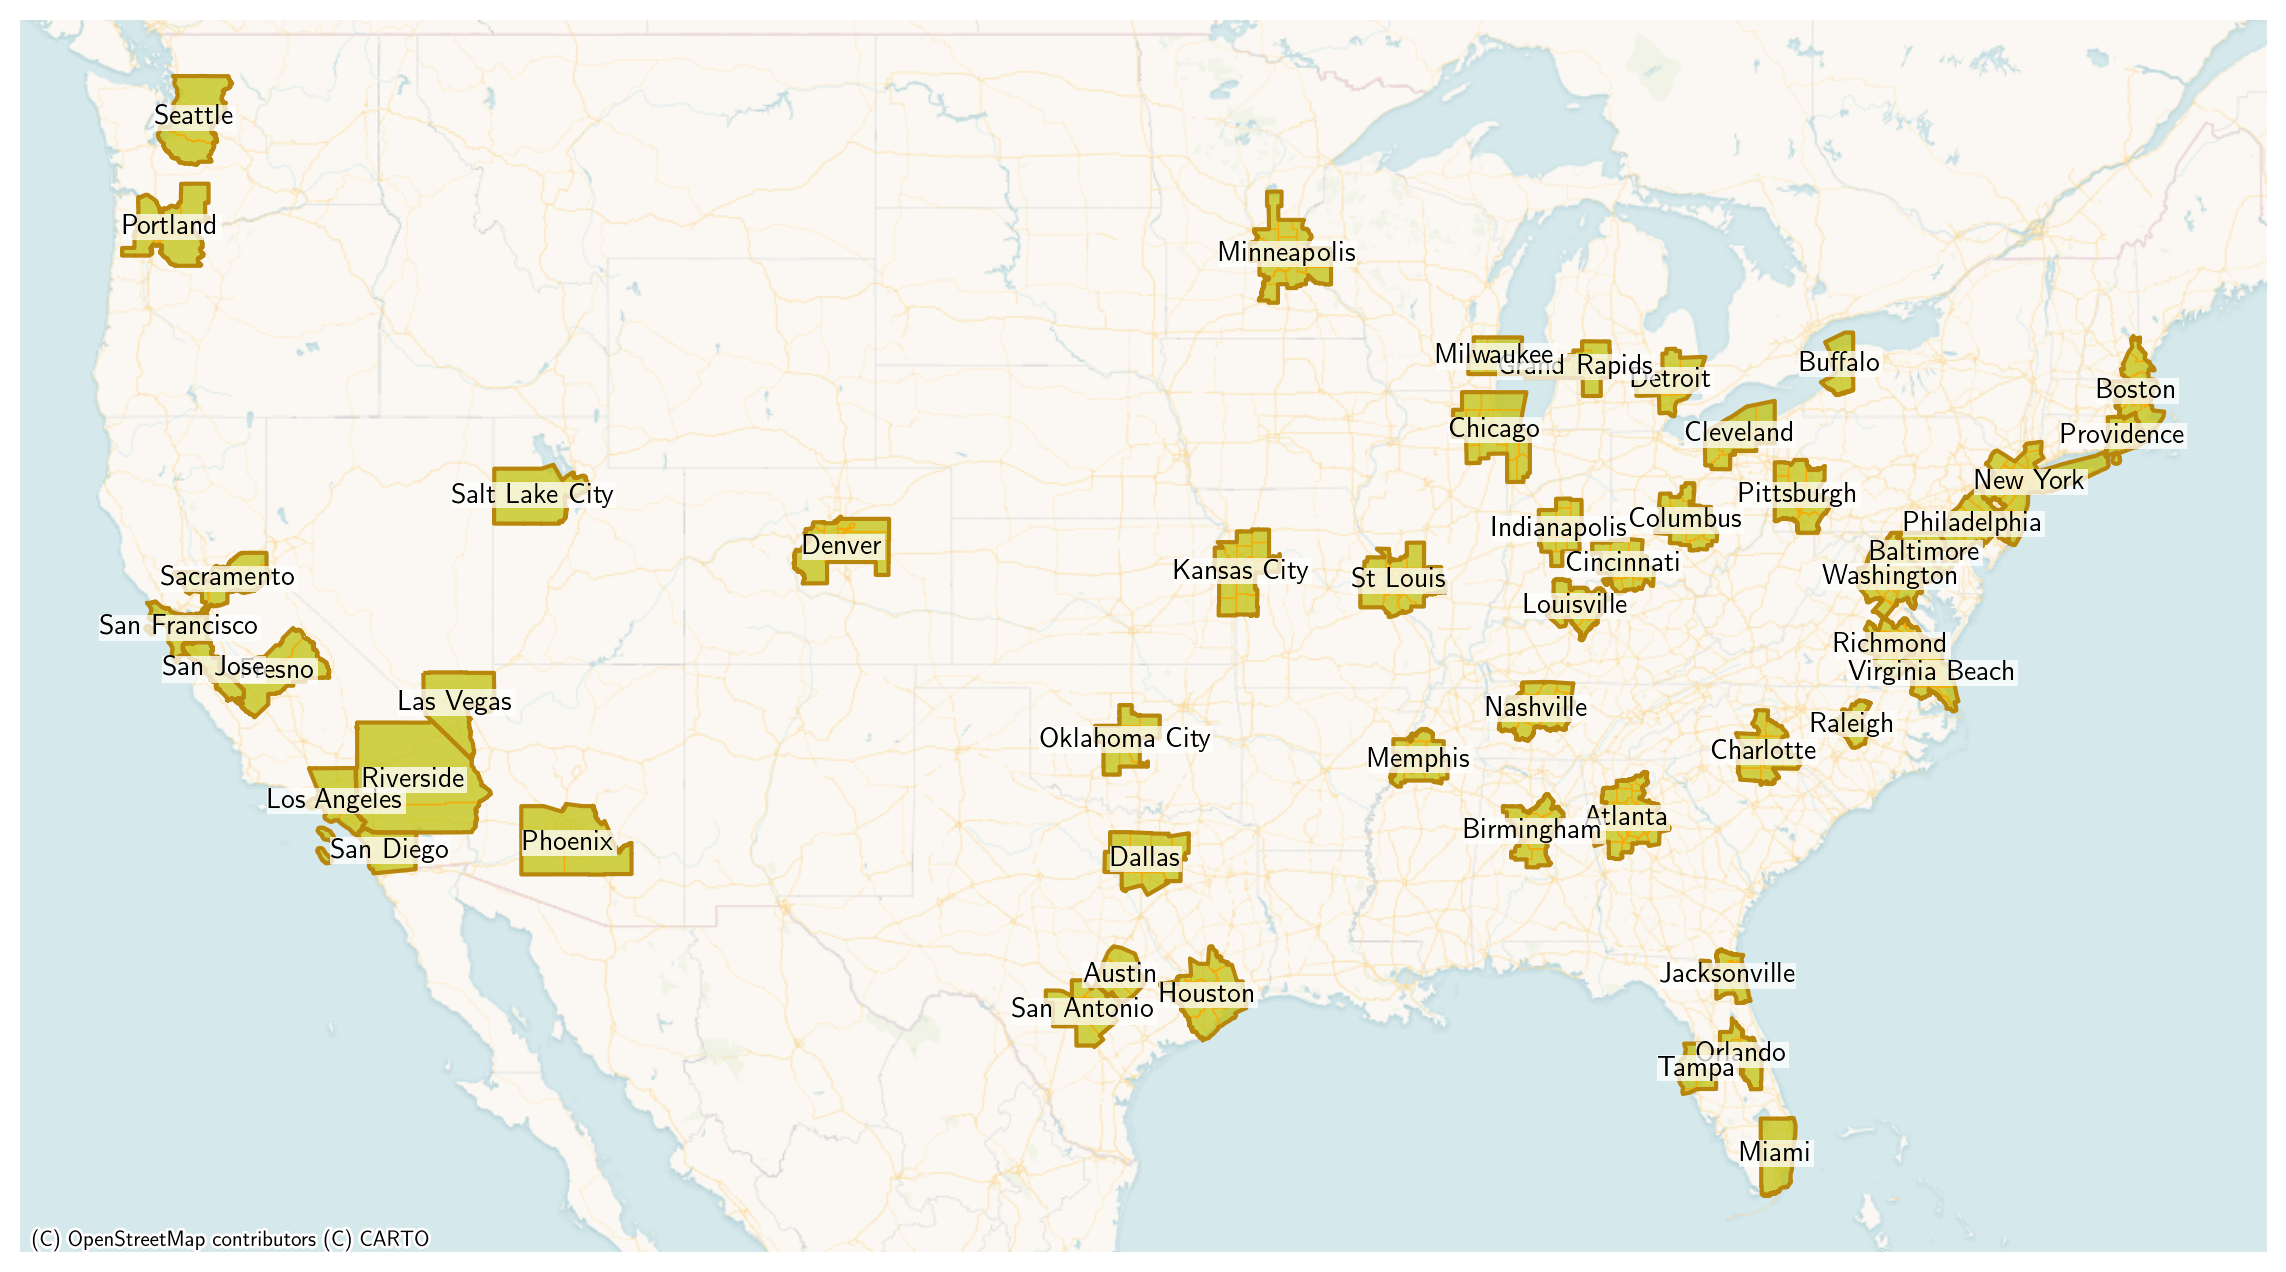

In [23]:
# t=0:11
ax = pplot(size=(20, 8), dpi=200, axoff=1)
msa20.plot(ax=ax, color='y', alpha=0.7, ec='orange', lw=0.5)
msa20.dissolve('region').plot(ax=ax, fc='none', ec='darkgoldenrod', lw=1.5)
for rgn, df in msa20.groupby('region'):
    cx, cy = list(df.dissolve().centroid.iloc[0].coords)[0]
    ax.text(cx, cy, rgn.replace('-', ' ').title(), fontweight='bold', 
            ha='center', va='center', fontsize=10,
            bbox=D(fc='w', ec='none', pad=0.3, alpha=0.75))
ctx.add_basemap(ax=ax, crs=CRS_M, source=ctx.providers.CartoDB.VoyagerNoLabels)